# This project analyzes a dataset of 260 caribou attributes and tracking locations over 28 years.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

caribou = pd.read_csv('individuals.csv')
locations = pd.read_csv('locations.csv')

C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
caribou.head()

,animal_id,sex,life_stage,pregnant,with_calf,death_cause,study_site,deploy_on_longitude,deploy_on_latitude,deploy_on_comments,deploy_off_longitude,deploy_off_latitude,deploy_off_type,deploy_off_comments
0,HR_151.510,f,NaN,NaN,NaN,NaN,Hart Ranges,NaN,NaN,NaN,NaN,NaN,unknown,NaN
1,GR_C04,f,NaN,NaN,NaN,NaN,Graham,NaN,NaN,NaN,NaN,NaN,unknown,NaN
2,GR_C03,f,NaN,NaN,NaN,NaN,Graham,NaN,NaN,NaN,NaN,NaN,unknown,NaN
3,HR_151.805,f,NaN,NaN,NaN,NaN,Hart Ranges,NaN,NaN,NaN,NaN,NaN,unknown,NaN
4,HR_151.760,f,NaN,NaN,NaN,NaN,Hart Ranges,NaN,NaN,NaN,NaN,NaN,unknown,NaN


# Looking for the most common causes of death

In [3]:
caribou['death_cause'].value_counts()

Predation - Wolf                                                                                     14
Unknown                                                                                              11
Unknown.  Suspected predation                                                                         7
Predation - Unknown predator                                                                          5
Unknown.  Suspected wolf predation                                                                    4
Predation - Grizzly                                                                                   3
Unknown.  Suspected wolf (or possibly wolverine) predation                                            1
Accidental, Collar Still in Field, Inaccessible                                                       1
Vehicle Collision                                                                                     1
Accidental.  Caught in tree well                                

# Checking the second dataframe to see how many columns, what datatype they are, how many null values, etc.

In [4]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249450 entries, 0 to 249449
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   event_id    249450 non-null  int64  
 1   animal_id   249450 non-null  object 
 2   study_site  249450 non-null  object 
 3   season      249450 non-null  object 
 4   timestamp   249450 non-null  object 
 5   longitude   249450 non-null  float64
 6   latitude    249450 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.3+ MB


# Filtering out wolf and grizzly attacks in the first dataframe into two new dataframes and joining them together. Later I will explore the unknown causes of death.

In [5]:
wolf_attacks = caribou[caribou['death_cause'] == 'Predation - Wolf']

In [6]:
grizzly_attacks = caribou[caribou['death_cause'] == 'Predation - Grizzly']

In [7]:
Predation = pd.concat([grizzly_attacks, wolf_attacks], axis=0)

# Joining the new dataframe I created with the location dataframe and only using wolf and grizzly attacks. Most attacks happened around the same area.

In [8]:
Predation_locations = pd.concat([Predation, locations], axis=1)

In [9]:
Attacks = Predation_locations[(Predation_locations.death_cause == 'Predation - Wolf')
                                       | (Predation_locations.death_cause == 'Predation - Grizzly')]

In [10]:
import folium
from folium import plugins
m = folium.Map(location=[43.651070, -79.347015], zoom_start=3, tiles='Stamen Terrain')

for (index, row) in Attacks.iterrows():
    folium.Marker(location=[row.loc['latitude'], row.loc['longitude']],
                 popup=row.loc['death_cause'],
                 tooltip='click').add_to(m)
    

m.add_child(folium.LatLngPopup())

m.save('index.html')

In [11]:
m

# Feature engineering

# Filling data with the Mode makes two assumptions: the data is missing at random and the missing data most likely looks like the rest of the data (the most frequent value).

In [12]:
caribou['with_calf'].isnull().sum()

202

In [13]:
caribou['with_calf'].mode()

0    False
dtype: object

In [14]:
caribou['with_calf'].fillna('False',inplace=True)

In [15]:
caribou['with_calf'].isnull().sum()

0

<AxesSubplot:>

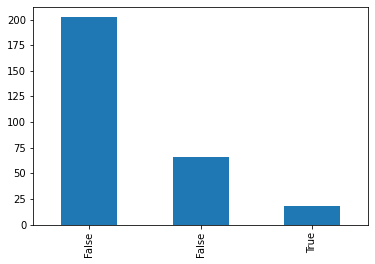

In [16]:
caribou['with_calf'].value_counts().plot.bar()

In [17]:
caribou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   animal_id             286 non-null    object 
 1   sex                   286 non-null    object 
 2   life_stage            67 non-null     object 
 3   pregnant              19 non-null     object 
 4   with_calf             286 non-null    object 
 5   death_cause           54 non-null     object 
 6   study_site            286 non-null    object 
 7   deploy_on_longitude   153 non-null    float64
 8   deploy_on_latitude    153 non-null    float64
 9   deploy_on_comments    87 non-null     object 
 10  deploy_off_longitude  56 non-null     float64
 11  deploy_off_latitude   56 non-null     float64
 12  deploy_off_type       286 non-null    object 
 13  deploy_off_comments   56 non-null     object 
dtypes: float64(4), object(10)
memory usage: 31.4+ KB


# It is safe to assume that the deploy off latitude and longitude are from the same coordinate range as the deploy on latitude and longitude.  The latitude location where the collars were deployed seems to come from a more specific location.

<AxesSubplot:ylabel='Density'>

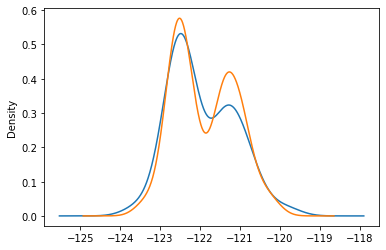

In [18]:
caribou['deploy_off_longitude'].plot(kind='kde')
caribou['deploy_on_longitude'].plot(kind='kde')

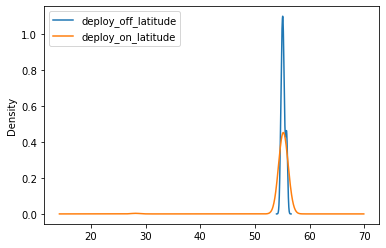

In [19]:
caribou['deploy_off_latitude'].plot(kind='kde')
caribou['deploy_on_latitude'].plot(kind='kde')
plt.legend()

<AxesSubplot:ylabel='Density'>

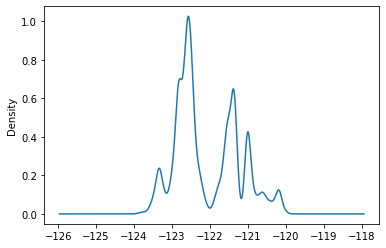

In [20]:
#It looks like there are 3 distinct locations where the caribou congregate over the time series but lets dig deeper
locations['longitude'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

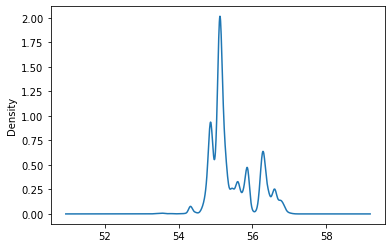

In [21]:
locations['latitude'].plot(kind='kde')

In [22]:
#The longitude coordinates were more spread out than the latitude coordinates
print('Deploy off longitude std:', caribou.deploy_off_longitude.std())
print('Deploy off latitude std:', caribou['deploy_off_latitude'].std())
print('Longitude std:', locations['longitude'].std())
print('Latitude std:', locations['latitude'].std())
print('Deploy off longitude mean:',caribou['deploy_off_longitude'].mean())
print('Deploy off latitude mean:',caribou['deploy_off_latitude'].mean())
print('Longitude mean:', locations['longitude'].mean())
print('Latitude mean:', locations['latitude'].mean())

Deploy off longitude std: 0.8025241611780284
Deploy off latitude std: 0.36017862441852727
Longitude std: 0.8366644017318057
Latitude std: 0.5940582098683101
Deploy off longitude mean: -121.94733101609343
Deploy off latitude mean: 55.20868143999373
Longitude mean: -122.08614984919674
Latitude mean: 55.43834909446871


In [23]:
caribou['deploy_off_type'].value_counts()

unknown    99
removal    82
dead       60
other      45
Name: deploy_off_type, dtype: int64

# Plotting the series over the years, starting in 1988 to 2016. No events were recorded from about 1991 to 2000. I'm not sure why, maybe the collars lost signal.  It is hard to believe that all the caribou disappeared and suddenly reappeared.

In [24]:
locations['timestamp'] = pd.to_datetime(locations['timestamp'])

In [25]:
year = locations['timestamp'].dt.year

<AxesSubplot:ylabel='Density'>

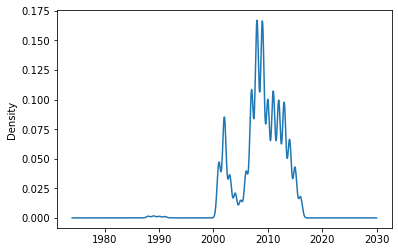

In [26]:
year.plot(kind='kde')

In [27]:
month = locations['timestamp'].dt.month

# There are 12 spikes here which I'll assume represents 12 months.  And I'll assume it's the same for each year.

<AxesSubplot:ylabel='Density'>

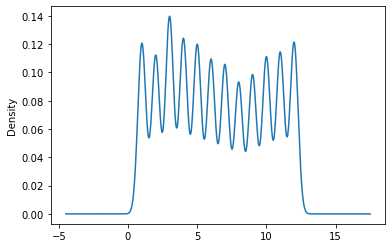

In [28]:
month.plot(kind='kde')

# I'm attempting to calculate the p-value for seeing a death occur over the whole time series.

In [29]:
abs(2016 - 1988)

28

In [30]:
28 * 365

10220

In [31]:
# .027 + .027 = .054 - there is a 5% chance of a death throughout the time series - seeing any deaths occur more than 5% 
#of the time i.e, .07 would be statistically significant
#I used 286 deaths for all deaths including null values and turned the number of years into days
286/10220

0.027984344422700588

# Merging both full dataframes. 250,000 location tags of 260 caribuo were observed from 1988 to 2016. That's why the location dataframe is so much bigger than the caribuo dataframe. https://www.kaggle.com/jessemostipak/caribou-location-tracking

In [32]:
All_locations = caribou.merge(locations, how='inner')

In [33]:
All_locations.isnull().sum() / len(All_locations)

animal_id               0.000000
sex                     0.000000
life_stage              0.570222
pregnant                0.981129
with_calf               0.000000
death_cause             0.829406
study_site              0.000000
deploy_on_longitude     0.334481
deploy_on_latitude      0.334481
deploy_on_comments      0.636028
deploy_off_longitude    0.843577
deploy_off_latitude     0.843577
deploy_off_type         0.000000
deploy_off_comments     0.785317
event_id                0.000000
season                  0.000000
timestamp               0.000000
longitude               0.000000
latitude                0.000000
dtype: float64

In [34]:
All_locations.drop(['deploy_on_comments','deploy_off_longitude','deploy_off_latitude','deploy_off_comments'], axis=1, inplace=True)

# Logistic regression

# Can the study site and the season of the observation be used to determine the sex?  This could be used to determine breeding grounds, when females give birth and if there is a higher number of predators are around during certain times when the caribou are present.  This information can help officials establish protected areas, warn locals when higher numbers of predators are around.

In [35]:
X = All_locations[['study_site', 'season']]


In [36]:
X['study_site'].unique()

array(['Hart Ranges', 'Graham', 'Kennedy', 'Moberly', 'Quintette',
       'Burnt Pine', 'Narraway', 'Scott'], dtype=object)

In [37]:
X['season'].unique()

array(['Winter', 'Summer'], dtype=object)

In [38]:
X['study_site'] = pd.factorize(X['study_site'])[0]
X['season'] = pd.factorize(X['season'])[0]

In [39]:
import sklearn 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
ohe = OneHotEncoder().fit_transform(X)

In [40]:
y = All_locations[['sex']]

In [41]:
y.value_counts()

sex
f      294029
m        2194
dtype: int64

In [42]:
le = sklearn.preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [43]:
print(X.shape)
print(y.shape)

(296223, 2)
(296223,)


In [44]:
# 99% of caribou in the dataframe are female
294029 / len(y)

0.9925934177967275

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

In [46]:
#Scaling data to improve computing time
#Normalizes each feature to normal distribution - mu=0 and sigma = 1
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=True)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

# Even though there is 89% accuracy, the classes were very unbalanced so the model still might need more features to correctly classify the different genders.  For this model I think recall is the more important metric.

In [47]:
#By default the penalty is ridge regression
#When using stratify above my accuracy went up about 15 percent
#Stratify keeps the same poportion of classes as before the split
#'ovr' - a binary problem is fit to each class
#accuracy went up 3% using ovr instead of multinominal but recall dropped almost 50% and precision dropped 1% for class 1 which
# is male
#iterations over 100 the accuracy drops to 75%
from sklearn.linear_model import LogisticRegression
logR = LogisticRegression(class_weight='balanced', random_state=0, solver='saga', max_iter=100, multi_class='multinomial')
logR.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=0, solver='saga')

In [48]:
predictions = logR.predict(X_test)

In [49]:
# Recall - Poprotion of true positives that were correctly classified - TP/TP + FN
# Precision - Correctly clasified observations - TP/TP +FP
# F1-Score - Weighted average of precision and recall - 2*(Recall * Precison) / (Recall + Precision)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     88209
           1       0.06      0.96      0.12       658

    accuracy                           0.89     88867
   macro avg       0.53      0.92      0.53     88867
weighted avg       0.99      0.89      0.94     88867



In [50]:
# TP, FN
# FP, TN
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[78636  9573]
 [   28   630]]


# Changing index in locations to datetime.

In [51]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249450 entries, 0 to 249449
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   event_id    249450 non-null  int64              
 1   animal_id   249450 non-null  object             
 2   study_site  249450 non-null  object             
 3   season      249450 non-null  object             
 4   timestamp   249450 non-null  datetime64[ns, UTC]
 5   longitude   249450 non-null  float64            
 6   latitude    249450 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 13.3+ MB


In [52]:
locations['timestamp'].dtype

datetime64[ns, UTC]

In [53]:
#locations['timestamp'].astype(str)

In [54]:
#locations['timestamp'] = pd.to_datetime(locations['timestamp'])

In [55]:
locations = locations.set_index(locations.timestamp)

In [56]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249450 entries, 2001-02-21 05:00:00+00:00 to 2007-07-28 23:27:00+00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   event_id    249450 non-null  int64              
 1   animal_id   249450 non-null  object             
 2   study_site  249450 non-null  object             
 3   season      249450 non-null  object             
 4   timestamp   249450 non-null  datetime64[ns, UTC]
 5   longitude   249450 non-null  float64            
 6   latitude    249450 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 15.2+ MB


# Cluster

# Is the pattern in the time series random or is there a reason behind it?

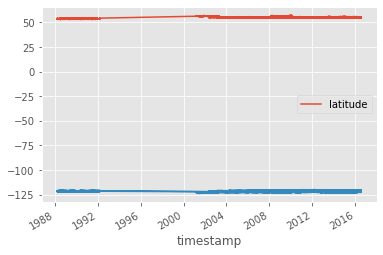

In [57]:
plt.style.use('ggplot')
locations['latitude'].plot()
plt.plot(locations['longitude'])
plt.legend()

In [58]:
coordinates = locations[['latitude', 'longitude']]
print(coordinates['latitude'].unique())
print(coordinates['longitude'].unique())

[56.23949645 56.23984703 56.24000269 ... 55.12618007 55.11519178
 55.11820695]
[-122.52004879 -122.52241613 -122.52317251 ... -121.35184388 -121.34679276
 -121.31107207]


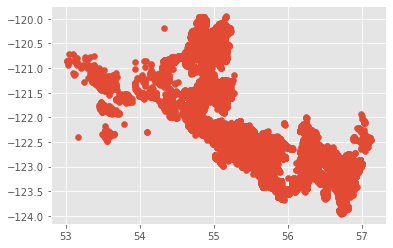

In [59]:
plt.scatter(coordinates['latitude'], coordinates['longitude'])

In [60]:
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249450 entries, 2001-02-21 05:00:00+00:00 to 2007-07-28 23:27:00+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   249450 non-null  float64
 1   longitude  249450 non-null  float64
dtypes: float64(2)
memory usage: 5.7 MB


In [61]:
from sklearn.cluster import KMeans

# There seems to be some kind of pattern between the coordinates. Food availability, predators or breeding grounds could be the reason for this.  All these coordinates range from just southeast of the Kwadacha Wilderness Provincial Park south towards Bowron Lake Provincial Park. This graph and the next two, comparing event_id and both latitude and longitude, show which locations have more events. Lines of latitude run north and south  and lines of longitude run east and west.

In [62]:
#Assigns data points to the closest centroid using the Euclidean distance
#Euclidean distance - sqrt(x - a)^2 + (y-b)^2
#n_init - Number of time the k-means algorithm will be run with different centroid seeds.
#max_iter - Maximum number of iterations of the k-means algorithm for a single run
km = KMeans(n_init=300, max_iter =200)
preds = km.fit_predict(coordinates)
coordinates['preds'] = preds

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

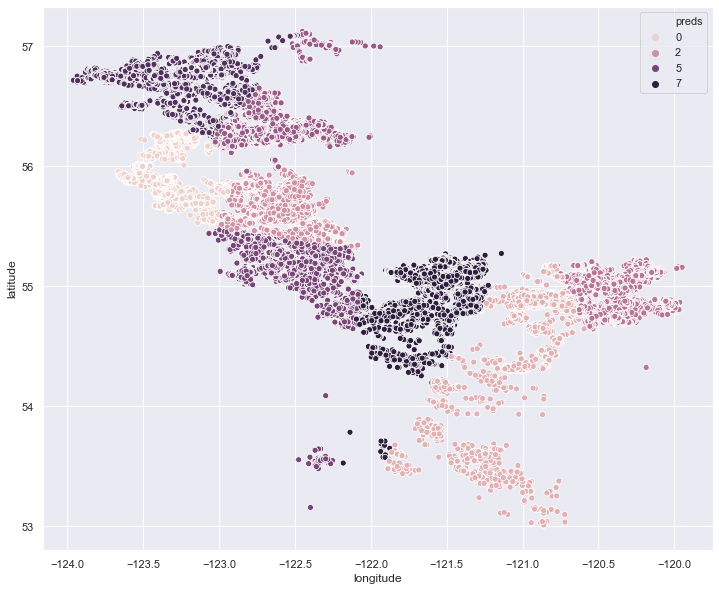

In [63]:
sns.set(rc={'figure.figsize':(12,10)})
sns.scatterplot('longitude', 'latitude', hue=coordinates['preds'], data=coordinates)

In [64]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249450 entries, 2001-02-21 05:00:00+00:00 to 2007-07-28 23:27:00+00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   event_id    249450 non-null  int64              
 1   animal_id   249450 non-null  object             
 2   study_site  249450 non-null  object             
 3   season      249450 non-null  object             
 4   timestamp   249450 non-null  datetime64[ns, UTC]
 5   longitude   249450 non-null  float64            
 6   latitude    249450 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(3)
memory usage: 15.2+ MB


In [65]:
cluster = locations[['event_id', 'latitude']]

In [66]:
km2 = KMeans(n_init=300, max_iter =200)
preds2 = km2.fit_predict(cluster)
cluster['preds2'] = preds2

<AxesSubplot:xlabel='event_id', ylabel='latitude'>

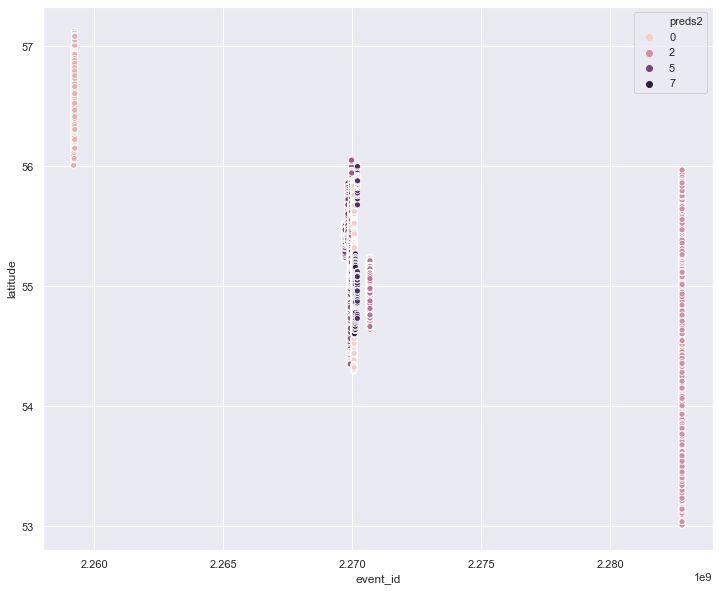

In [67]:
sns.set(rc={'figure.figsize':(12,10)})
sns.scatterplot('event_id', 'latitude', hue=cluster['preds2'], data=cluster)

In [68]:
cluster2 = locations[['event_id', 'longitude']]

In [69]:
km3 = KMeans(n_init=300, max_iter =200)
preds3 = km3.fit_predict(cluster2)
cluster2['preds3'] = preds3

<AxesSubplot:xlabel='event_id', ylabel='longitude'>

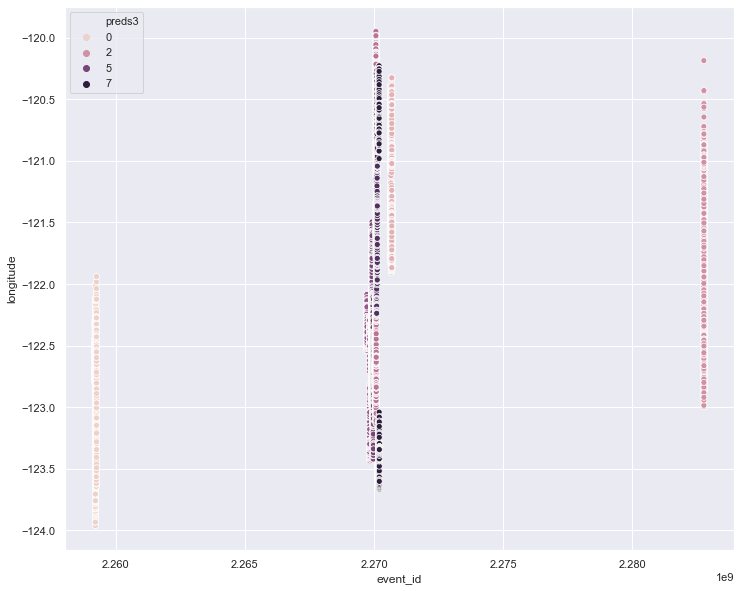

In [70]:
sns.set(rc={'figure.figsize':(12,10)})
sns.scatterplot('event_id', 'longitude', hue=cluster2['preds3'], data=cluster2)

# Predator-Prey model
# The first equation is the growth of the prey population
# The second equation is the growth of the predator population

In [71]:
def pred_prey_system(t, y):
    return np.array([5*y[0] - 0.1*y[0]*y[1], 0.1*y[1]*y[0] - 6*y[1]])

In [72]:
p = np.linspace(0, 100, 25)
w = np.linspace(0, 100, 25)
P, W = np.meshgrid(p, w)

In [73]:
dp, dw = pred_prey_system(0, np.array([P, W]))

Text(0, 0.5, 'Predator')

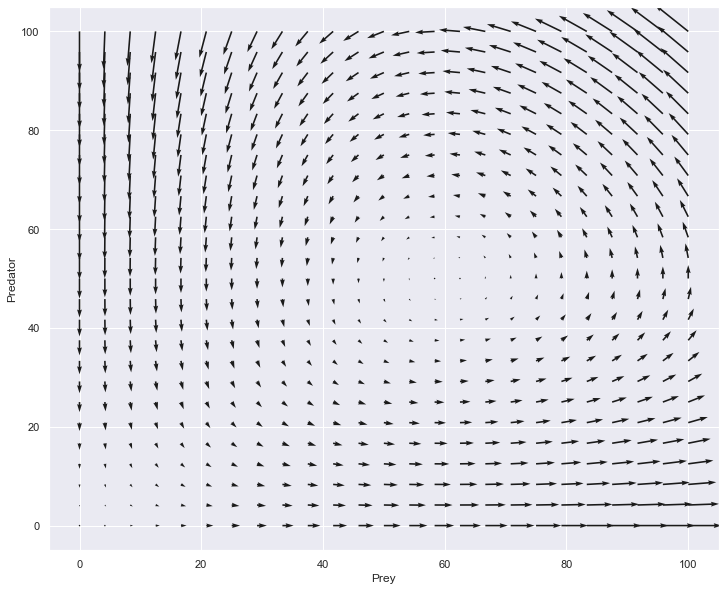

In [74]:
fig, ax = plt.subplots()
ax.quiver(P, W, dp, dw)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')

In [75]:
initial_conditions = np.array([85, 40])
from scipy import integrate
sol = integrate.solve_ivp(pred_prey_system,(0., 5.), initial_conditions, max_step=0.01)

Text(0, 0.5, 'Predator')

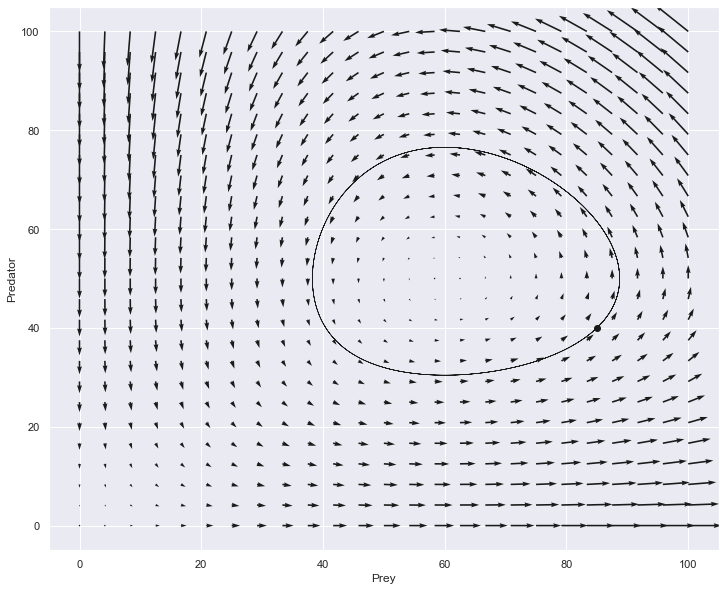

In [76]:
fig, ax = plt.subplots()
ax.quiver(P, W, dp, dw)
ax.plot(initial_conditions[0], initial_conditions[1], "ko")
ax.plot(sol.y[0, :], sol.y[1, :], "k", linewidth=0.5)
ax.set_xlabel('Prey')
ax.set_ylabel('Predator')

# These predator-prey models can be useful when introducing a species in a certain environment to prevent everything from becoming unbalanced.  When I begin the process of starting my own nonprofit and repopulating or creating my own wildlife refugee, these models will come in handy.